In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import bartlett
from scipy.stats import levene
from sklearn.neighbors import KNeighborsRegressor
%matplotlib inline

In [2]:
happy_df = pd.read_csv('../Data/HappinessAlcoholConsumption.csv')
happy_df.head()

,Country,Region,Hemisphere,HappinessScore,HDI,GDP_PerCapita,Beer_PerCapita,Spirit_PerCapita,Wine_PerCapita
0,Denmark,Western Europe,north,7.526,928,53.579,224,81,278
1,Switzerland,Western Europe,north,7.509,943,79.866,185,100,280
2,Iceland,Western Europe,north,7.501,933,60.530,233,61,78
3,Norway,Western Europe,north,7.498,951,70.890,169,71,129
4,Finland,Western Europe,north,7.413,918,43.433,263,133,97


In [3]:
happy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 9 columns):
Country             122 non-null object
Region              122 non-null object
Hemisphere          122 non-null object
HappinessScore      122 non-null float64
HDI                 122 non-null int64
GDP_PerCapita       122 non-null float64
Beer_PerCapita      122 non-null int64
Spirit_PerCapita    122 non-null int64
Wine_PerCapita      122 non-null int64
dtypes: float64(2), int64(4), object(3)
memory usage: 8.7+ KB


No data appears to be missing and the datatypes are appropriate, let's visualize the numeric values to confirm everything looks okay.

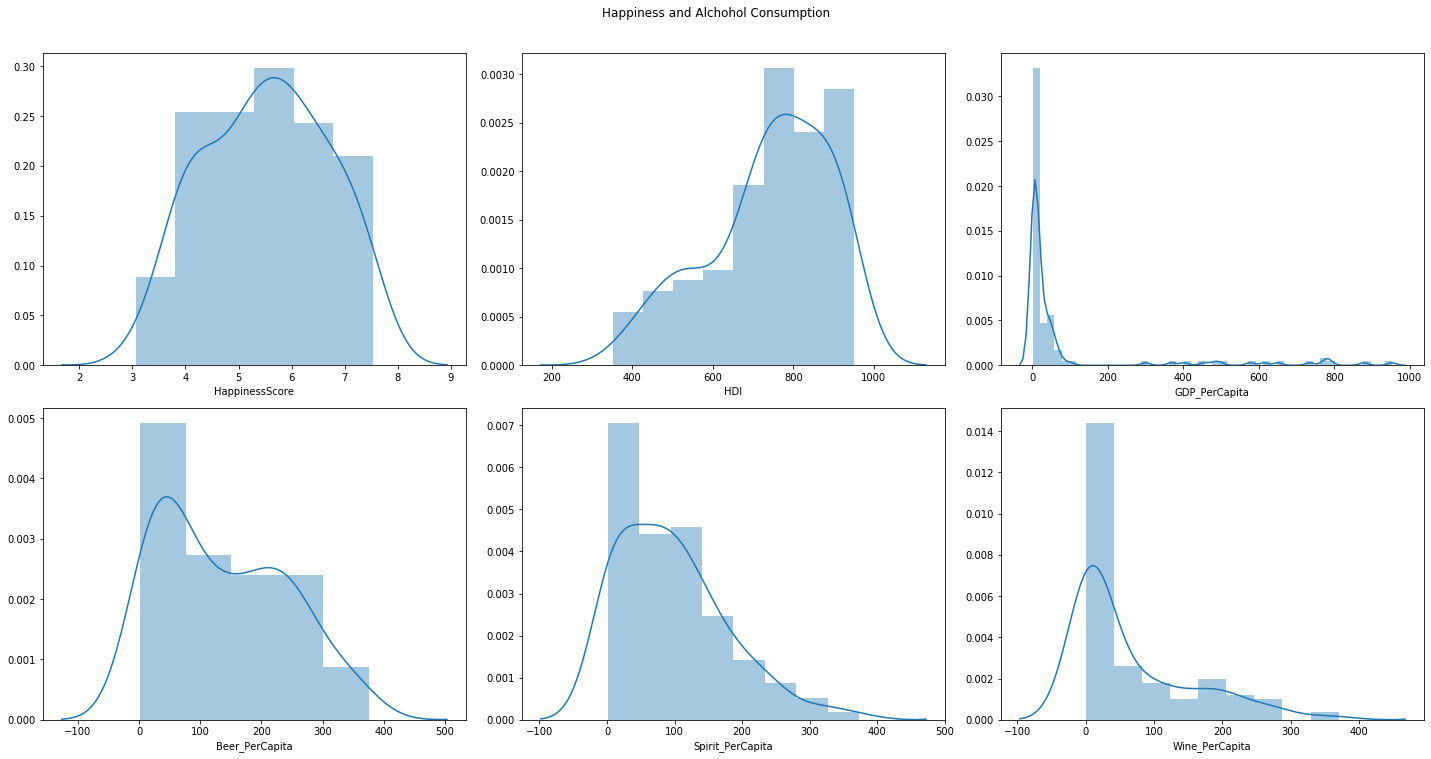

In [4]:
# Visualize distributions of data
num_vars = happy_df.columns[3:]

fig, axes = plt.subplots(2,3,figsize=(20,10))

for i in range(len(num_vars)):
    sns.distplot(happy_df[num_vars[i]], ax=axes[int(i/3),i%3])
    
plt.suptitle('Happiness and Alchohol Consumption', y=1.05)
plt.tight_layout()
plt.show()

The data does not appear to have any erroneous values. Let's see how our model performs!

# OLS Model

In [41]:
#Sort data into dependent and independent variables
Y = happy_df['HappinessScore']
X = happy_df.loc[:,('HDI','GDP_PerCapita', 'Beer_PerCapita', 'Spirit_PerCapita', 'Wine_PerCapita')]
X = sm.add_constant(X.values)

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=2)

lrm = LinearRegression(fit_intercept=True)

lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)


ols_r2_train = lrm.score(X_train, y_train)
ols_r2_test = lrm.score(X_test, y_test)
ols_mae = mean_absolute_error(y_test, y_preds_test)
ols_mse = mse(y_test, y_preds_test)
ols_rmse = rmse(y_test, y_preds_test)
ols_mape = np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100

print("R-squared of the model in training set is: {}".format(ols_r2_train))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ols_r2_test))
print("Mean absolute error of the prediction is: {}".format(ols_mae))
print("Mean squared error of the prediction is: {}".format(ols_mse))
print("Root mean squared error of the prediction is: {}".format(ols_rmse))
print("Mean absolute percentage error of the prediction is: {}".format(ols_mape))

R-squared of the model in training set is: 0.6822828994452839
-----Test set statistics-----
R-squared of the model in test set is: 0.6397452792400675
Mean absolute error of the prediction is: 0.6969809034074872
Mean squared error of the prediction is: 0.6155432547385772
Root mean squared error of the prediction is: 0.7845656471822974
Mean absolute percentage error of the prediction is: 12.996688098903828


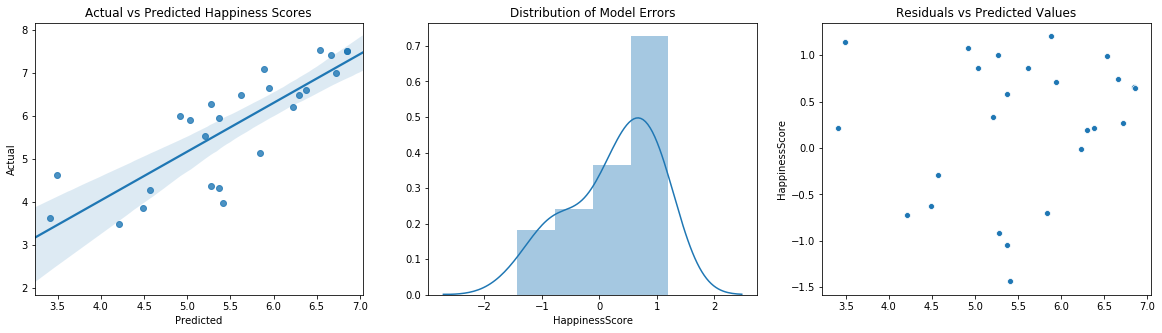

In [20]:
predictions = results.predict(X_test)
errors = y_test - predictions

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.regplot(x=predictions, y=y_test)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Actual vs Predicted Happiness Scores')

plt.subplot(1,3,2)
sns.distplot(errors)
plt.title('Distribution of Model Errors')

plt.subplot(1,3,3)
sns.scatterplot(predictions, errors)
plt.title('Residuals vs Predicted Values')

plt.show()

In [21]:
bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

norm_stat = stats.normaltest(errors)

print('Normal test statistic for the model errors is {0:3g} and the p value is {1:.3g}'.format(norm_stat[0], norm_stat[1]))

Bartlett test statistic value is 1.3726 and p value is 0.241
Levene test statistic value is 1.11467 and p value is 0.296
Normal test statistic for the model errors is 2.77451 and the p value is 0.25


The residual errors are normaly distributed and homoscedastic. Let's see if a KNN regression model can perform better than the OLS model.

# KNN Model

We will need to adjust the scale of our data before we can proceed with the KNN regressor model.

In [27]:
z_df = happy_df.copy()

for var in ('HDI','GDP_PerCapita', 'Beer_PerCapita', 'Spirit_PerCapita', 'Wine_PerCapita'):
    z_df.loc[:,var] = stats.zscore(z_df[var])

In [42]:
Y = z_df['HappinessScore']
X = z_df.loc[:,('HDI','GDP_PerCapita', 'Beer_PerCapita', 'Spirit_PerCapita', 'Wine_PerCapita')]
X = sm.add_constant(X.values)

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train,y_train)

# We are making predictions here
y_preds_train = knn.predict(X_train)
y_preds_test = knn.predict(X_test)

knn_r2_train = knn.score(X_train, y_train)
knn_r2_test = knn.score(X_test, y_test)
knn_mae = mean_absolute_error(y_test, y_preds_test)
knn_mse = mse(y_test, y_preds_test)
knn_rmse = rmse(y_test, y_preds_test)
knn_mape = np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100

print("R-squared of the model in training set is: {}".format(knn_r2_train))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(knn_r2_test))
print("Mean absolute error of the prediction is: {}".format(knn_mae))
print("Mean squared error of the prediction is: {}".format(knn_mse))
print("Root mean squared error of the prediction is: {}".format(knn_rmse))
print("Mean absolute percentage error of the prediction is: {}".format(knn_mape))

R-squared of the model in training set is: 0.7848586269814277
-----Test set statistics-----
R-squared of the model in test set is: 0.734261866048616
Mean absolute error of the prediction is: 0.539552
Mean squared error of the prediction is: 0.45404905600000006
Root mean squared error of the prediction is: 0.6738316228851241
Mean absolute percentage error of the prediction is: 10.251511395755658


# Model Comparison

To ease the comparison of our models, let's find the differences between the models in our statistics. All differences will be calculated with KNN - OLS; therefore positive values indicate a higher value for the KNN model while negative values indicate a higher value for the OLS model.

In [47]:
print("Difference in R-squared between the models in the training set is: {}".format(knn_r2_train - ols_r2_train))
print("-----Test set statistics-----")
print("Difference in R-squared between the models in the test set is: {}".format(knn_r2_test - ols_r2_train))
print("The difference in Mean absolute error of the prediction is: {}".format(knn_mae - ols_mae))
print("The difference in Mean squared error of the prediction is: {}".format(knn_mse - ols_mae))
print("The difference in Root mean squared error of the prediction is: {}".format(knn_rmse - ols_mae))
print("The difference in Mean absolute percentage error of the prediction is: {}".format(knn_mape - ols_mape))

Difference in R-squared between the models in the training set is: 0.10257572753614386
-----Test set statistics-----
Difference in R-squared between the models in the test set is: 0.05197896660333212
The difference in Mean absolute error of the prediction is: -0.15742890340748716
The difference in Mean squared error of the prediction is: -0.24293184740748713
The difference in Root mean squared error of the prediction is: -0.02314928052236309
The difference in Mean absolute percentage error of the prediction is: -2.7451767031481698


The KNN regression model was more performant than the OLS regression model in every statistic measured. R^2 values were larger and all measures of error were lower. While this is true for the current dataset, KNN regressors likely have fewer applications in the real world when compared to OLS regressions. While a linear regression can theoretically predict trends that extend outside of a dataset, a KNN regressor will be unable to accurately predict values that are outside of the range of values in the training set.